In [18]:
import torch
import pandas as pd
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# File details
filename: str = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/forecast_gdp_europe.csv"
file_tag: str = "GDP_Europe"
target: str = "GDP"
timecol: str = "Year"
measure: str = "R2"

# Load the dataset
data: pd.DataFrame = pd.read_csv(
    filename, 
    index_col=timecol, 
    sep=",", 
    decimal=".", 
    parse_dates=True
)
series = data[[target]].values.astype("float32")

# Split the dataset into training and testing sets
train_size = int(len(series) * 0.90)  # Use 90% of the data for training
train, test = series[:train_size], series[train_size:]

# Prepare dataset for LSTM
def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []  # List to store input sequences
    setY: list = []  # List to store target sequences
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]  # Past sequence
        future = series[i + seq_length]  # Single target value
        setX.append(past)
        setY.append(future)
    return torch.tensor(setX, dtype=torch.float32), torch.tensor(setY, dtype=torch.float32)

# Define the LSTM-based model
class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        # Prepare training data
        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(
            TensorDataset(trnX.view(-1, length, input_size), trnY), 
            shuffle=True, 
            batch_size=len(train) // 10
        )

    def forward(self, x):
        x, _ = self.lstm(x)  # Forward pass through LSTM
        x = self.linear(x[:, -1, :])  # Linear layer for the last output only
        return x

    def fit(self):
        self.train()  # Set the model to training mode
        for batchX, batchY in self.loader:  # Iterate over data loader
            y_pred = self(batchX)  # Predict the output
            loss = self.loss_fn(y_pred, batchY)  # Calculate loss
            self.optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Backpropagation
            self.optimizer.step()  # Update parameters
        return loss.item()  # Return the loss value

    def predict(self, X):
        with no_grad():  # Disable gradient computation
            y_pred = self(X.view(-1, X.size(1), 1))  # Predict using the model
        return y_pred.squeeze()  # Return the prediction

# Instantiate the model with the training data
model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1, length=4)

# Train the model and calculate the loss
loss = model.fit()

# Print the final loss after training
print(f"Final Loss: {loss}")

# Make predictions
testX, _ = prepare_dataset_for_lstm(test, seq_length=4)
predictions = model.predict(testX)
print(f"Predictions: {predictions}")


Final Loss: 8065003.5
Predictions: tensor([0.2435, 0.2435])


seq length=2 hidden_units=25 nr_episodes=0 -376.1675720214844
seq length=2 hidden_units=25 nr_episodes=300 -375.087646484375
seq length=2 hidden_units=25 nr_episodes=600 -374.044677734375
seq length=2 hidden_units=25 nr_episodes=900 -373.00286865234375
seq length=2 hidden_units=25 nr_episodes=1200 -371.9627380371094
seq length=2 hidden_units=25 nr_episodes=1500 -370.9284362792969
seq length=2 hidden_units=25 nr_episodes=1800 -369.8951416015625
seq length=2 hidden_units=25 nr_episodes=2100 -368.8627624511719
seq length=2 hidden_units=25 nr_episodes=2400 -367.8330383300781
seq length=2 hidden_units=25 nr_episodes=2700 -366.803955078125
seq length=2 hidden_units=25 nr_episodes=3000 -365.777099609375
seq length=2 hidden_units=50 nr_episodes=0 -376.1553649902344
seq length=2 hidden_units=50 nr_episodes=300 -373.64215087890625
seq length=2 hidden_units=50 nr_episodes=600 -371.100830078125
seq length=2 hidden_units=50 nr_episodes=900 -368.6014404296875
seq length=2 hidden_units=50 nr_episodes

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

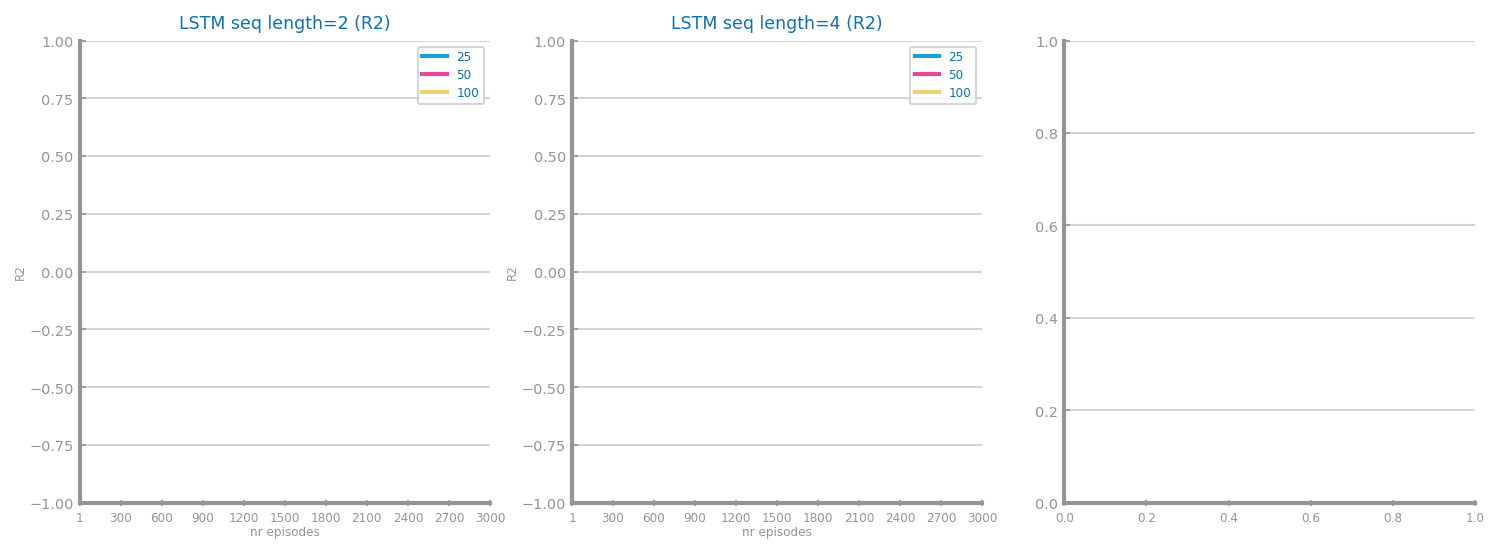

In [20]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        # Ensure tstX has the correct dimensions for LSTM
        tstX = tstX.view(-1, length, 1)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)


In [21]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstms_{measure}_eval.png")

NameError: name 'best_params' is not defined

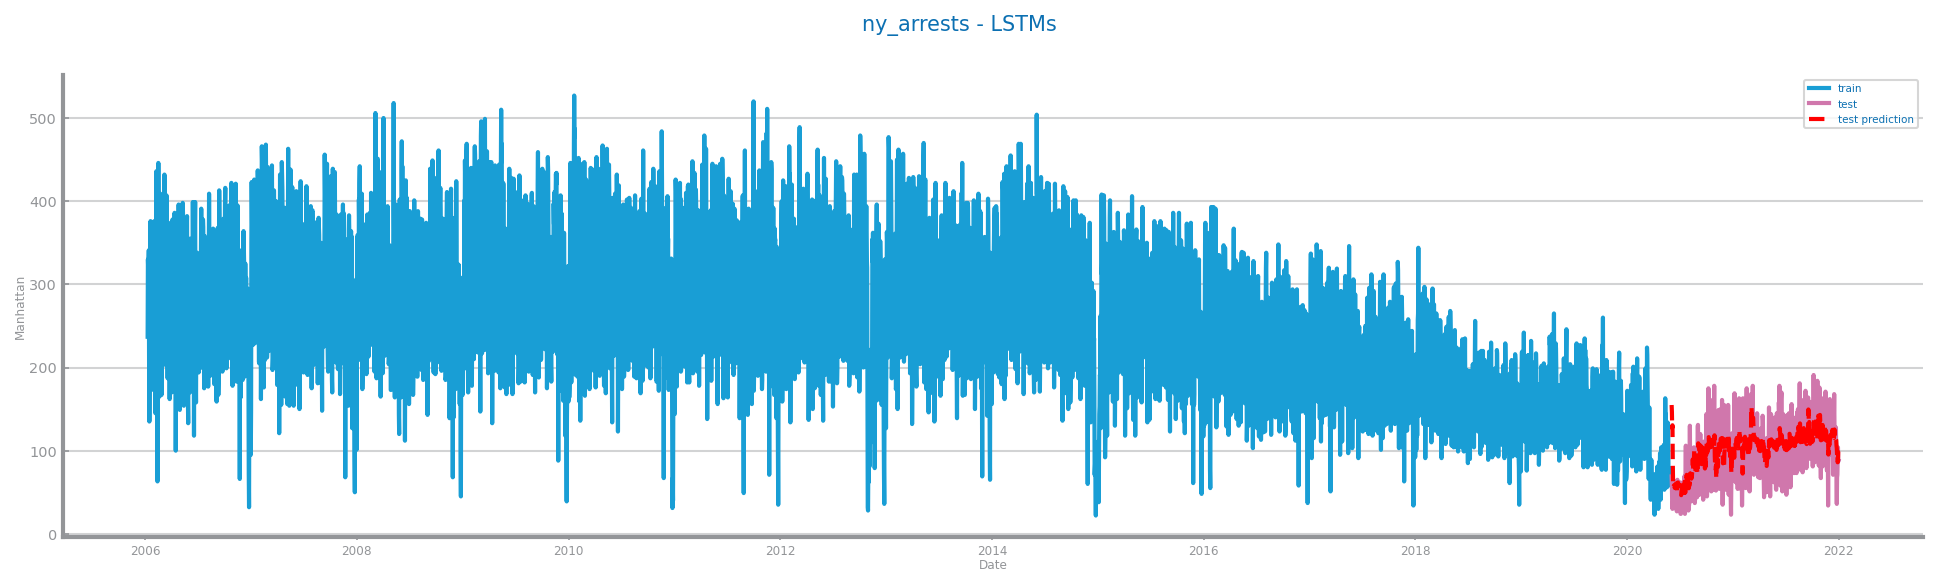

In [7]:
from dslabs_functions import plot_forecasting_series

series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_lstms_{measure}_forecast.png")